# Face Emotion Recognition

### Project Introduction
The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms. Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge. In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to a lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analyzed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analyzed and tracked.

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.The solution to this problem is by recognizing facial emotions.

### Importing Libraries
Importing the required python libraries like numpy, seaborn, matplotlib, tensorflow

In [1]:
# Importing all the required Libraries

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential                                                            
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np 
import cv2
import os

# Removing all those annoying Warnings

import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
#dowload the data and add the path
my_data_dir = 'C:\\Users\\Ultimatrix\\Downloads\\face_recog\\data'

In [3]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
#setting up test and train path
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
#list the directory of test path
os.listdir(test_path)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
#list the directory of trian path
os.listdir(train_path)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
#getting the first image of angry folder
os.listdir(train_path+'\\angry')[0]

'Training_10118481.jpg'

In [8]:
img =train_path+'\\angry'+'\\Training_10118481.jpg'

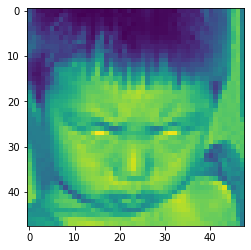

In [9]:
#showing the first image of angry folder
plt.imshow(imread(img))

## Setup the data generators
Now we will generate training and testing (validation) batches.

### Image Manipulation

Its usually a good idea to manipulate the images with scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us

In [10]:
# Creating Image generators, for all train, validation, and test set
training_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)

In [11]:
# Creating  Training Dataset

train_gen=training_gen.flow_from_directory(train_path,                
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

# Creating Test Set

test_gen=testing_gen.flow_from_directory(test_path,                                       
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


- Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.
As of now we have imported libraries, got dataset, and created train and test images.

In [12]:
#printing the class indicies og train_gen
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Data Visualization
The dataset consists of 2 folders - training and test All the images of dataset are grayscale images of size 48,48 Both these folders consist of 7 folders each.All these 7 folders contain images of peoples faces with respective emotion. We deleted 2 folders out of 7 which consisted of least numbers of images so that our model can train better on other model and give better accuracy. (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains approximately 36K images

Dataset is converted into raw images and splitted in multiple folders which are train and validation folders.
80% of our images are contained inside the train folder, and the last 20% are inside the validation folder.

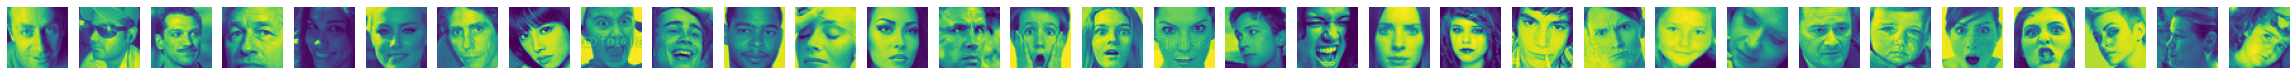

happy   neutral   happy   sad   happy   neutral   neutral   neutral   angry   happy   neutral   sad   neutral   sad   surprise   surprise   surprise   neutral   angry   fear   sad   neutral   angry   neutral   fear   sad   sad   surprise   angry   neutral   sad   sad   

In [13]:
# Extracting next batch to plot it, this batch of photos are selected randomly

imgs,lables=next(train_gen)

# list of Classes

list_of_keys=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']                  

def plotImages(images_arr):
  fig, axes= plt.subplots(1,32,figsize=(32,2))
  axes= axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)

# Printing the lables below the respective image

for i in lables[:32]:                                                                             
  for num, j in enumerate(i):
    if j==1:
      print(list_of_keys[num], end='   ')  # Labelling seems to be spot on                                                            
num+=1

## Building the CNN Model.
We chose to use a Convolutional Neural Network in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.

Now let's define the architecture of our CNN:

In [14]:
# from keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#output layer
model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

We define our CNN with the following global architecture:

- 4 convolutional layers
- 2 fully connected layers

Basic CNN architecture details:

- Input layer - Input layer in CNN should contain image data
- Convo layer - Convo layer is sometimes called feature extractor layer because features of the image are get extracted within this layer
- Pooling layer - Pooling is used to reduce the dimensionality of each features while retaining the most important information. It is used between two convolution layer
- Fully CL - Fully connected layer involves weights, biases, and neurons. It connects neurons in one layer to neurons in another layer. It is used to classify images between different category by training and placed before the output layer
- Output Layer - Output layer contains the label which is in the form of one-hot encoded

Also we use some common techniques for each layer

Batch normalization: improves the performance and stability of NNs by providing inputs with zero mean and unit variance.
Dropout: reduces overfitting by randomly not updating the weights of some nodes. This helps prevent the NN from relying on one node in the layer too much.

## Train the model
Now it’s time to train the model and evaluate the results.

In [15]:
# Adding various Call Backs Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

checkpoint = ModelCheckpoint('./my_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')          # Adding various Call Backs Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

#early stopping

early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)
decay_lr= ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=3,
                           verbose=1,
                           min_delta=0.0001)
callbacks=[early_stopping,checkpoint,decay_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [16]:
#fitting the generator

results = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=40,
                                validation_data = test_gen,
                                validation_steps = test_gen.n//test_gen.batch_size,
                                callbacks=callbacks
                                )

Epoch 1/40
897/897 [==============================] - 557s 620ms/step - loss: 1.7112 - accuracy: 0.3428 - val_loss: 1.5210 - val_accuracy: 0.3963 - lr: 0.0010
Epoch 2/40
897/897 [==============================] - 520s 580ms/step - loss: 1.3715 - accuracy: 0.4733 - val_loss: 1.3612 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 3/40
897/897 [==============================] - 522s 582ms/step - loss: 1.2530 - accuracy: 0.5230 - val_loss: 1.2031 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 4/40
897/897 [==============================] - 522s 582ms/step - loss: 1.1804 - accuracy: 0.5496 - val_loss: 1.1667 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 5/40
897/897 [==============================] - 524s 584ms/step - loss: 1.1284 - accuracy: 0.5709 - val_loss: 1.1446 - val_accuracy: 0.5598 - lr: 0.0010
Epoch 6/40
897/897 [==============================] - 573s 639ms/step - loss: 1.0709 - accuracy: 0.5930 - val_loss: 1.1579 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 7/40
897/897 [==========================

- Our best model managed to obtain a accuracy of approximately 82% and val_accuracy of 65% on the dataset by running 40 epochs.which is quite good.
- At each epoch, Keras checks if our model performed better than the models of the previous epochs.

In [17]:
# Predicting For Test Set
predictions=model.predict(test_gen)

# Printing Confution Matrix
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                                  # Printing Confution Matrix  
cm

array([[ 501,   24,  110,   50,  129,  126,   18],
       [  24,   69,    5,    4,    1,    5,    3],
       [  84,   15,  496,   37,  114,  181,   97],
       [  35,    1,   46, 1498,  103,   57,   34],
       [  60,    5,   86,   96,  788,  182,   16],
       [ 113,    7,  176,   71,  212,  648,   20],
       [  17,    1,   73,   42,   16,   14,  668]], dtype=int64)

In [18]:
 # Accuracy Score of Our Model
acc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)
acc       

0.6503204235162998

## Saving Model

In [19]:
model.save('model/my_CNN_model.h5')

## Plotting Accuracy & Loss to analyze the results

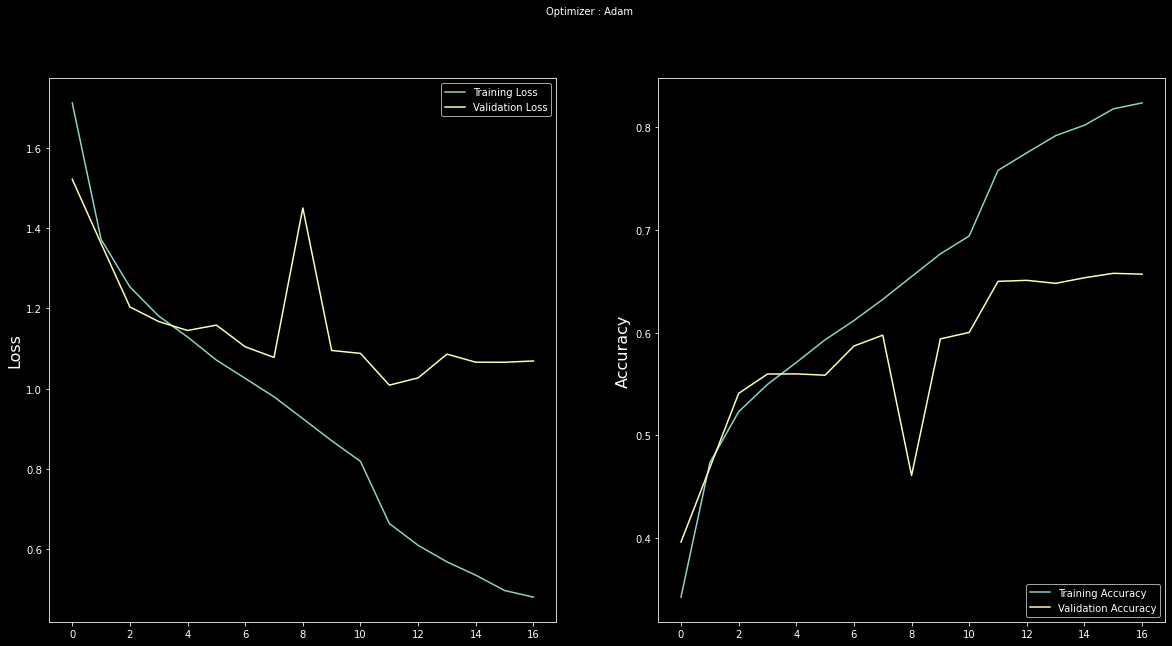

In [21]:
#Plotting Accuracy & Loss
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

- The training gave the accuracy of 84% and val_accuracy of 65%. It seems good. So, I save the model and detection I got from live video is good.
- The training loss is slightly higher than the validation loss for the first epochs.

### Confusion matrix
Finally we can plot the confusion matrix in order to see how our model classified the images:

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

<Figure size 432x288 with 0 Axes>

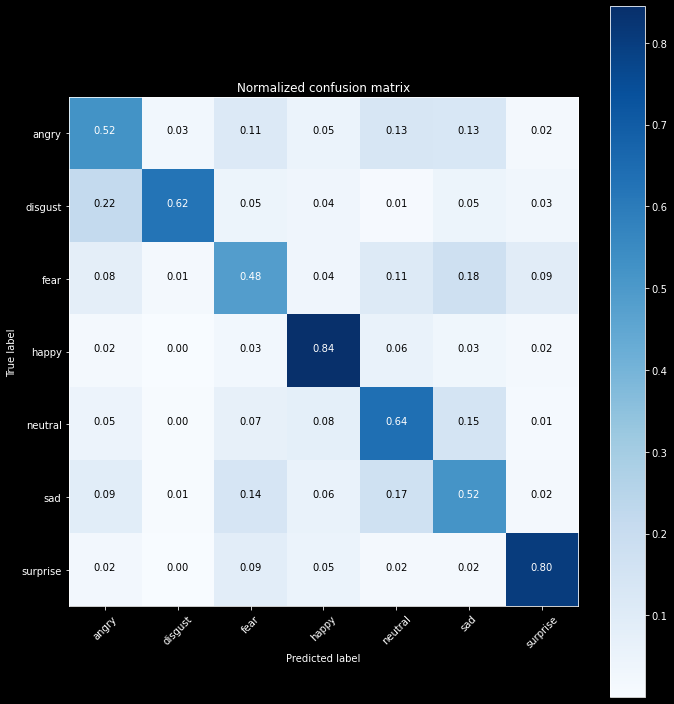

In [23]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=test_gen)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_gen.classes
class_names = test_gen.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces maybe because it confuses them with sad faces.